<a href="https://colab.research.google.com/github/Sriyoshija/task4/blob/main/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values before dropping column:
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0


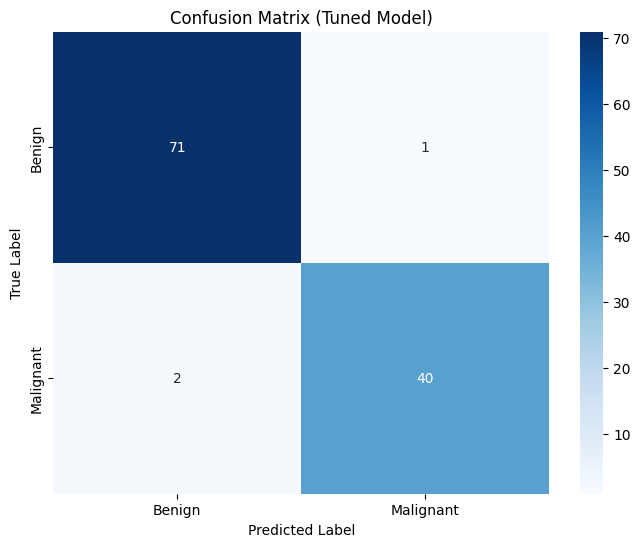

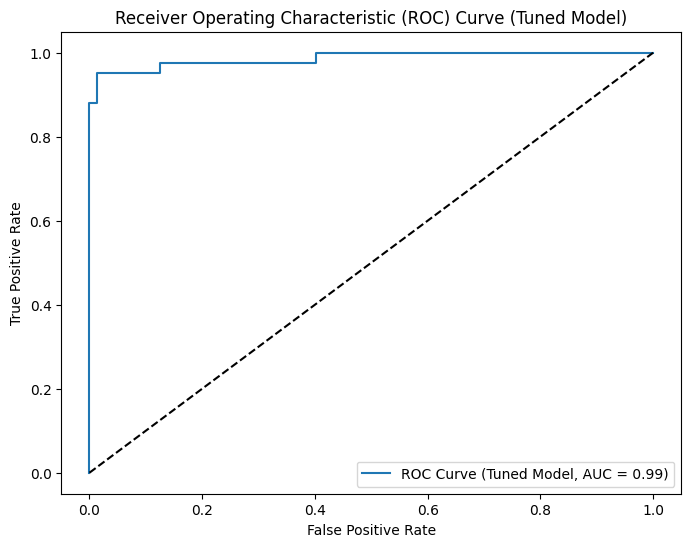

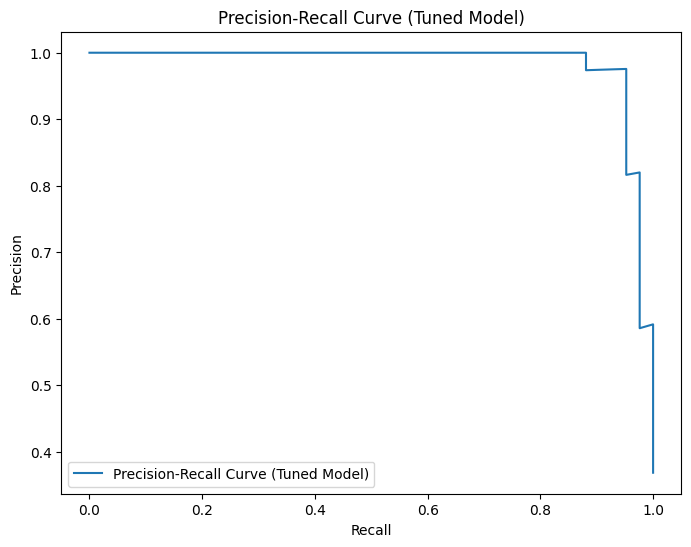


Top 5 most influential features (Tuned Model):
            Feature  Coefficient  Absolute_Impact
10        radius_se     3.391195         3.391195
21    texture_worst     3.255318         3.255318
26  concavity_worst     2.588488         2.588488
13          area_se     2.568691         2.568691
28   symmetry_worst     2.525842         2.525842


/tmp/ipython-input-16-4224246110.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Absolute_Impact', y='Feature', data=coef_df_tuned.head(10), palette='viridis')


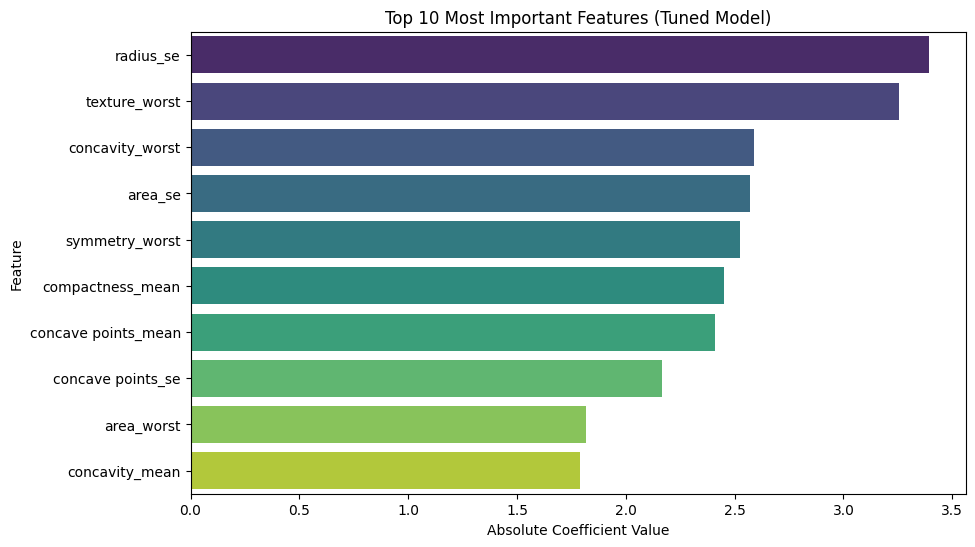

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve,
                            PrecisionRecallDisplay)

df = pd.read_csv('/content/data.csv')
df = df.drop('id', axis=1)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

#Check for missing values and drop the column
print("Missing values before dropping column:")
print(df.isnull().sum())
df = df.dropna(axis=1, how='all')
print("\nMissing values after dropping column:")
print(df.isnull().sum())

print(f"\nDataset shape: {df.shape}")
print(f"Class distribution:\n{df['diagnosis'].value_counts()}")

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

#Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain-test split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

#Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticregression', LogisticRegression(max_iter=1000))
])
print("\nPipeline created successfully.")

#Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("\nCross-validation scores (ROC AUC):", cv_scores)
print("Mean CV ROC AUC score:", cv_scores.mean())
print("Standard deviation of CV ROC AUC scores:", cv_scores.std())

#Tune hyperparameters
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(grid_search.best_params_)

print("\nBest cross-validation ROC AUC score:")
print(grid_search.best_score_)

#Evaluate the tuned model
best_estimator = grid_search.best_estimator_
y_pred_tuned = best_estimator.predict(X_test)
y_prob_tuned = best_estimator.predict_proba(X_test)[:, 1]

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))

plt.figure(figsize=(8, 6))
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix (Tuned Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_tuned.png', dpi=300)
plt.show()

fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, label=f'ROC Curve (Tuned Model, AUC = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Tuned Model)')
plt.legend()
plt.savefig('roc_curve_tuned.png', dpi=300)
plt.show()

precision_tuned, recall_tuned, _tuned = precision_recall_curve(y_test, y_prob_tuned)

plt.figure(figsize=(8, 6))
plt.plot(recall_tuned, precision_tuned, label='Precision-Recall Curve (Tuned Model)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Tuned Model)')
plt.legend()
plt.savefig('precision_recall_curve_tuned.png', dpi=300)
plt.show()

#Analyze feature importance
tuned_logreg_model = best_estimator.named_steps['logisticregression']
coefficients_tuned = tuned_logreg_model.coef_[0]

coef_df_tuned = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients_tuned,
    'Absolute_Impact': np.abs(coefficients_tuned)
}).sort_values('Absolute_Impact', ascending=False)

print("\nTop 5 most influential features (Tuned Model):")
print(coef_df_tuned.head(5))

plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute_Impact', y='Feature', data=coef_df_tuned.head(10), palette='viridis')
plt.title('Top 10 Most Important Features (Tuned Model)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.savefig('feature_importance_tuned.png', dpi=300)
plt.show()